Need from Christa:

* signs of connections
* way to define input node (e.g. threshold or known position)
* tuning curves for each neuron w/ easy way to map onto indices of cxn matrix

Challenges:

* need to specify intrinsic time constants for non-input neurons
* need way to normalize response strengths of input neurons
* need way to put measured weights into correct "units"
* how to compare model results with data, neuron by neuron basis? or in distribution?

Go node-by-node, rank order by most inputs

cxns_noDup = connectivity matrix. 

Each entry is # of synapses between a single neuron pair. Presynaptic partner goes down the rows, postsynaptic partner goes across the columns. 
    
lineNames_nosub = the name of each cell type (or split-GAL4 line). Each cell type contains 1 to >100 individual neurons, and some cell types are split into subtypes (ie, 'B1-1, 'B1-2', etc)

neuronNames = name of each neuron in the connectivity matrix. Each name is unique. The beginning part of the name indicates which cell type the neuron is from (ie, '16374_L1' is from cell type 16374, and 'WV-WV-1_L1' is from cell type WV-WV).

I have ignored the diagonal values (which would represent autapses) by inserting NaNs. In my connectivity diagram, I have also ignored connections between individual neurons that belong to the same cell type due to the high rate of false positives of the automatically detected synapses in these cases. 

For the current connectome figure, I set a threshold of 15 synapses between one single pair of neurons to indicate a likely connection, and then required at least 3% of all possible connections between two cell types (in one direction) to cross this threshold.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
import sys

from aux import loadmat_h5
from disp import set_font_size

DATA_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn.mat'

In [13]:
data = loadmat_h5(DATA_FILE)
print(data.keys())

w = data['cxns_noDup']
print(w)
n = w.shape[0]

dict_keys(['cxns_noDup', 'lineNames_nosub', 'neuronNames'])
[[ nan  42. 133. ...   0.   0.   0.]
 [ 55.  nan  77. ...   0.   0.   0.]
 [ 31.  44.  nan ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  nan   1.   6.]
 [  0.   0.   0. ...   7.  nan  11.]
 [  0.   0.   0. ...   3.   0.  nan]]


In [3]:
data['lineNames_nosub']

array([['A1', 'A2', 'B1', 'B2', 'GF', 'WED-VLP', 'WV-WV', '16374',
        '27885', '27936', '36007', '37007', '40303', '41728', '41730',
        '43299', '21914', '29146', '35996', '47261', '23281', '27932',
        '29136', '35916', '36012', '38918', '40316', '41739', '45858',
        'vpoEN', 'vpoIN', 'pMN1', 'pMN2', 'pC2', 'pC1']], dtype=object)

In [4]:
data['neuronNames'].T

array([['A1_L1', 'A1_L2', 'A1_L3', 'A1_R1', 'A1_R2', 'A2_L', 'A2_R',
        'B1-1_L1', 'B1-1_L2', 'B1-1_L3', 'B1-1_L4', 'B1-1_L5', 'B1-1_L6',
        'B1-1_R1', 'B1-1_R2', 'B1-1_R3', 'B1-1_R4', 'B1-1_R5', 'B1-1_R6',
        'B1-2_L1', 'B1-2_L2', 'B1-2_L3', 'B1-2_L4', 'B1-2_L5', 'B1-2_L6',
        'B1-2_L7', 'B1-2_L8', 'B1-2_L9', 'B1-2_R1', 'B1-2_R2', 'B1-2_R3',
        'B1-2_R4', 'B1-2_R5', 'B1-2_R6', 'B1-2_R7', 'B1-2_R8', 'B1-3_L1',
        'B1-3_L2', 'B1-3_L3', 'B1-3_L4', 'B1-3_L5', 'B1-3_R1', 'B1-3_R2',
        'B1-3_R3', 'B1-3_R4', 'B1-3_R5', 'B1-4_L1', 'B1-4_L2', 'B1-4_L3',
        'B1-4_L4', 'B1-4_L5', 'B1-4_L6', 'B1-4_L7', 'B1-4_L8', 'B1-4_L9',
        'B1-4_R1', 'B1-4_R2', 'B1-4_R3', 'B1-4_R4', 'B1-4_R5', 'B1-4_R6',
        'B1-4_R7', 'B1-4_R8', 'B1-u_L1', 'B1-u_L2', 'B1-u_L3', 'B1-u_L4',
        'B1-u_L5', 'B1-u_L6', 'B1-u_L7', 'B1-u_L8', 'B1-u_L9',
        'B1-u_L10', 'B1-u_L11', 'B1-u_L12', 'B1-u_L13', 'B1-u_L14',
        'B1-u_L15', 'B1-u_L16', 'B1-u_L17', 'B1-u_L18', 'B1-

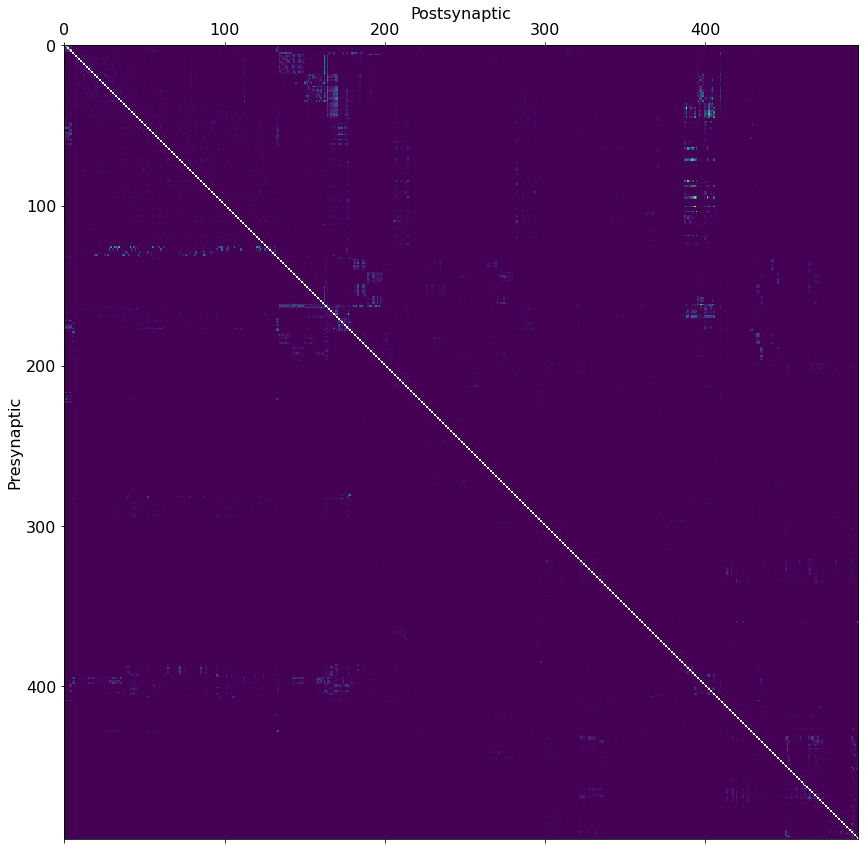

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), tight_layout=True)
ax.matshow(w)
ax.set_xlabel('Postsynaptic')
ax.set_ylabel('Presynaptic')
ax.xaxis.set_label_position('top')

set_font_size(ax, 16)

In [40]:
w_th = 5
cxn = (w > w_th)
n_pre = cxn.sum(axis=0)
print(f'n_pre: {n_pre}')
mstarts = (n_pre == 0)
istarts = mstarts.nonzero()[0]
print(f'start nodes: {istarts}')

n_pre: [29 21 25 36 30 12 12  4  8  2  3  4 10  1  5  5  8  6  6  4  7  5  4  4
  3  7  2  8 13 10 15 12 13 12  8  7  4  5 10 12  9  8 13 11 13  5  5  4
  4  7  2  4 13  2  8  6 12  6  2  9  9  1  6  0 12  8  1  0  0  0  0 11
 14  2  9  8  4  0  9 11  1  4  4  0  0 11  1  8  9  0  0  6  3  1  1 15
  8  2  7  0  0 18  4  1  5  2  5  3  0  1  3  1 14  0  0  0  0 10  1  7
  5  5  8  0  6  6  3  2  4  3  2  4 30 35 17 13 12 10 20 18 15  8 18 18
 14 13 18 21 16 16 10 14 15 16 10 12 14 15 18 15 23 14 62 31 81 33 45 38
 52 50 48 20 30 19 13 27 51 40 13  7  7 12  7 16  7  8 13 17  8 13  8 11
 11 13  5 14  6 12 10  1  7  3  0  3  2 11  9 21 18  3 12  3 15 12 21  1
  1  0  1  1  1  3  1  2  1  0  9  2  0  1  9  1  1  0  6  0  5  8  0  0
  1  0  1  0  1  0  1  0  6  3  4  1  0  0  0  0  2  1  2  0  0  0  0  0
  5  1  1  1  3  7 10  2  4  5 12  8  3  5  4  1  3  2 19  1  1  2  8  6
  2  4  7  2  1 12  6 10  1  3  2  1  3  4  0  5  2  1  0  2  0  2  0  1
  0  2  3  0  0  0  0  0  5  5 11  7  9  0  

In [41]:
# get start node time courses
from scipy.ndimage import gaussian_filter1d as smooth

t_off = 10
t_max = 20

t_down = np.arange(0, t_max, 1/8.5)
mstim = t_down < t_off

rs_start_down = []
for istart in istarts:
    r = np.zeros(len(t_down))
    r[mstim] = 1 - np.exp(-t_down[mstim]/2)
    r[~mstim] = np.exp(-(t_down[~mstim]-10)/2)
    
    # smooth response
    r = smooth(r, 3)
    rs_start_down.append(r.copy())

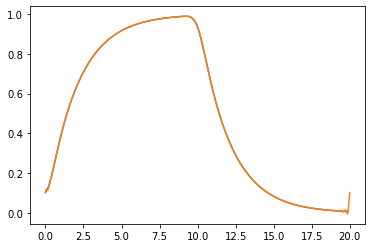

In [43]:
plt.plot(t_down, rs_start_down[0])
plt.plot(t, rs_start[0])

In [44]:
# model
dt = .001
t = np.arange(0, t_max, dt)

# upsample to simulation timescale
from scipy.signal import resample
rs_start = np.array([resample(r_start_down, len(t), t=t_down)[0] for r_start_down in rs_start_down])

# Linear model

$$\tau \frac{d\mathbf{r}}{dt} = -\mathbf{r} + J\mathbf{r}$$

where we clamp the responses of the start nodes to their measured values. We would like to see if such clamped inputs combined with measured weights from the connectome give rise to the variety of response timecourses seen in the downstream recurrently connected network.

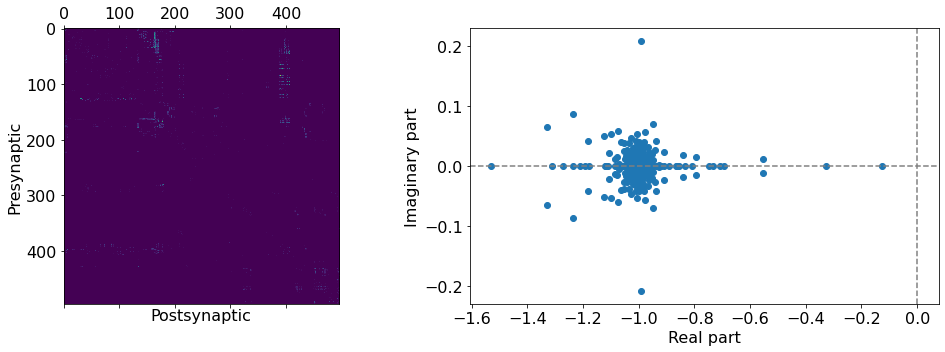

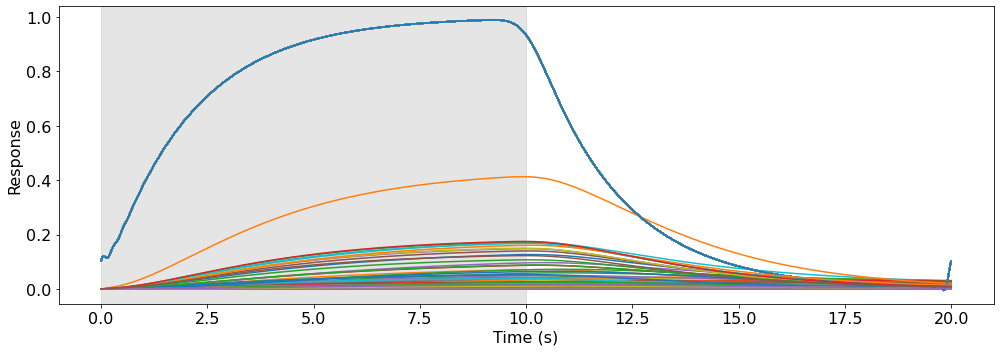

In [77]:
tau = 2
j_scale = .002
w_smln = w.copy()
w_smln[~cxn] = 0
j = j_scale * w_smln.T  # we need presynaptic columns and postsynaptic rows for the matrix equation

rs = np.nan * np.zeros((n, len(t)))
rs[:, 0] = 0
rs[mstarts, 0] = rs_start[:, 0]

for ct, t_ in enumerate(t[1:], 1):
    r_prev = rs[:, ct-1]
    dr = (dt/tau)*(-r_prev + j@r_prev)
    
    rs[~mstarts, ct] = r_prev[~mstarts] + dr[~mstarts]
    rs[mstarts, ct] = rs_start[:, ct]

fig, axs = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
axs[0].matshow(j.T)
axs[0].set_xlabel('Postsynaptic')
axs[0].set_ylabel('Presynaptic')

evals = np.linalg.eig(j - np.eye(n))[0]
axs[1].scatter(np.real(evals), np.imag(evals))
axs[1].set_xlabel('Real part')
axs[1].set_ylabel('Imaginary part')

axs[1].axhline(0, color='gray', ls='--')
axs[1].axvline(0, color='gray', ls='--')

set_font_size(axs, 16)
    
fig, ax = plt.subplots(1, 1, figsize=(14, 5), tight_layout=True)
ax.plot(t, rs.T)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Response')
ax.axvspan(0, t_off, color='gray', alpha=.2)

set_font_size(ax, 16)